In [1]:
from google.colab import auth

auth.authenticate_user()

In [2]:
%%bash
pip3 install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199674 sha256=5f7248696d58dfe8954f2dc1ad99a226db86a37cdc50f12477d4e746df56f9d1
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import fasttext

In [6]:
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
-
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...
- [1 files][ 91.6 MiB/ 91.6 MiB]                                                
Operation completed over 1 objects/91.6 MiB.                                     


In [7]:
# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = "__label__positive"
dataset_neg_pd['label'] = "__label__negative"
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

<ipython-input-7-d0d7145b8249>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-7-d0d7145b8249>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])


In [8]:
N = len(dataset_pd)
val_data_size = int(0.1 * len(dataset_pd.index))
test_data_size = int(0.1 * len(dataset_pd.index))

dataset_train = dataset_pd[:N - val_data_size - test_data_size]
dataset_test = dataset_pd[N - test_data_size:]

# fasttext
np.savetxt(r'data.train.txt', dataset_train.values, fmt='%s')
np.savetxt(r'data.test.txt', dataset_test.values, fmt='%s')

In [73]:
model = fasttext.train_supervised('data.train.txt')
_, accuracy, _ = model.test('data.test.txt')
print("Accuracy: {}".format(accuracy))

Accuracy: 0.8283173523724789


# Evaluate Model

In [74]:
test_in = dataset_test["text"].tolist()

fasttext_labels = np.array(dataset_test["label"].tolist())
labels = np.zeros_like(fasttext_labels, dtype=float)
labels[fasttext_labels == '__label__negative'] = 1
labels[fasttext_labels == '__label__positive'] = 0

output = model.predict(test_in)

In [75]:
model_str = np.array(output[0]).squeeze()
model_conf = np.array(output[1]).squeeze()

preds = []
for i in range(len(model_str)):
  if model_str[i] == '__label__positive':
    preds.append([model_conf[i], 1 - model_conf[i]])
  else:
    preds.append([1 - model_conf[i], model_conf[i]])

preds = np.array(preds)

## Model calibration

In [76]:
def get_calibration_vecs(num_buckets, labels, confidences):
  """
  create vectors required for calibration

  args:
  num_buckets (int) : number of buckets to create
  labels (np.array) : 1-D labels of data (0 for the confidence vector passed, 1 else)
  confidences (np.array) : 1-D confidences of model of one class

  returns: corr_frac, conf_frac, num_in_bucket
    corr_frac (np.array) : fraction of correct preds in buckets
    conf_frac (np.array) : mean confidence in each bucket
    num_in_bucket (np.array) : number of samples in each bucket

  """
  positives = 1 - labels
  pos_confidences = confidences
  corr_frac = []
  conf_frac = []
  num_in_bucket = []

  for i in range(NUM_BUCKETS):
    mask = np.logical_and(pos_confidences >= i/NUM_BUCKETS, pos_confidences < (i+1)/NUM_BUCKETS)
    corr_frac.append(np.mean(positives[mask]))
    conf_frac.append(np.mean(pos_confidences[mask]))
    num_in_bucket.append(pos_confidences[mask].shape[0])


  corr_frac = np.array(corr_frac)
  conf_frac = np.array(conf_frac)
  num_in_bucket = np.array(num_in_bucket)


  return corr_frac, conf_frac, num_in_bucket


In [77]:
NUM_BUCKETS = 20
pos_preds = preds[:,0]

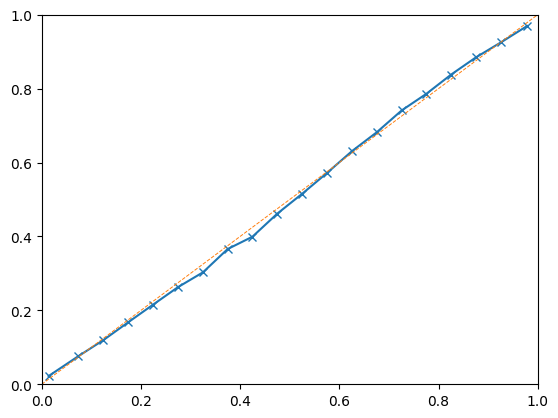

In [78]:
import matplotlib.pyplot as plt

corr_frac, conf_frac, num_in_bucket = get_calibration_vecs(NUM_BUCKETS, labels, pos_preds)


# plt.plot(np.linspace(1/(2*NUM_BUCKETS), 1-1/(2*NUM_BUCKETS), NUM_BUCKETS), corr_frac, '-o')
plt.plot(conf_frac, corr_frac, '-x')
plt.plot(np.array([0, 1]), np.array([0, 1]), "--", linewidth=0.7)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [72]:
# expected calibration error
ece = (1/np.sum(num_in_bucket)) * np.sum(num_in_bucket * np.abs(corr_frac - conf_frac))

# max calibration error
mce = np.max(np.abs(corr_frac - conf_frac))

print(f"ECE: {ece:.6f}")
print(f"MCE: {mce:.6f}")

ECE: 0.008712
MCE: 0.019791


## Accuracy